In [1]:
pip install yfinance pandas scikit-learn matplotlib seaborn


In [2]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor  # import from XGBoost library


from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Download data
ticker = 'RELIANCE.NS'  # change this to any stock
start_date = '2020-01-01'
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

data = yf.download(ticker, start=start_date, end=end_date)




/tmp/ipython-input-655114458.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [3]:
print(data.head(10))

Price            Close        High         Low        Open      Volume
Ticker     RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS
Date                                                                  
2020-01-01  675.324219  683.152914  673.490123  679.081997    14004468
2020-01-02  686.821228  689.348791  676.397899  676.397899    17710316
2020-01-03  687.648743  689.661834  681.318669  685.792191    20984698
2020-01-06  671.700623  683.510705  670.134872  679.976657    24519177
2020-01-07  682.034546  686.463335  677.068889  679.529321    16683622
2020-01-08  676.912354  686.440942  675.503202  677.739963    16047902
2020-01-09  692.502563  693.397244  685.009404  688.297445    14982742
2020-01-10  692.345947  696.953672  688.767105  694.247173    12478359
2020-01-13  690.579041  697.289325  688.208077  691.182980    18282382
2020-01-14  684.181885  693.397335  680.804375  688.923812    15816535


In [4]:

# Step 2: Preprocessing
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
data.dropna(inplace=True)

In [5]:
#creating features
data['High-Low'] = data['High'] - data['Low']
data['Close-Open'] = data['Close'] - data['Open']
data['5day_MA'] = data['Close'].rolling(window=5).mean()
data['10day_MA'] = data['Close'].rolling(window=10).mean()
data.dropna(inplace=True)

In [6]:
# Predicting next day Close price
data['Target'] = data['Close'].shift(-1)
data.dropna(inplace=True)

# Features and Target
features = data[['Open', 'High', 'Low', 'Close', 'Volume', 'High-Low', 'Close-Open', '5day_MA', '10day_MA']]
target = data['Target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

In [7]:

# Initialize the XGBoost model
model = XGBRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)


Root Mean Squared Error: 26.815439446798912
R2 Score: 0.9401776635239419
                 Actual    Predicted
Date                                
2025-07-31  1388.155762  1372.188843
2025-08-01  1405.885010  1385.002930
2025-08-04  1386.163696  1399.389526
2025-08-05  1387.259521  1382.354126
2025-08-06  1383.872925  1396.878418
2025-08-07  1362.358887  1378.346924
2025-08-08  1380.685669  1357.961914
2025-08-11  1374.908813  1377.550293
2025-08-12  1377.099976  1379.082275
2025-08-13  1373.800049  1364.990356


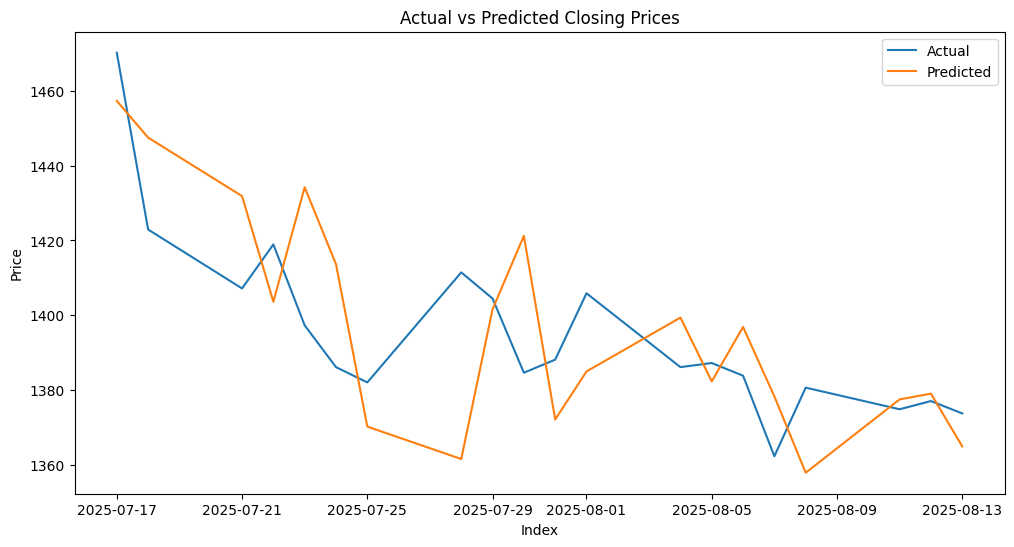

In [8]:
# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print("Root Mean Squared Error:", rmse)
print("R2 Score:", r2)

comparison = pd.DataFrame({'Actual': y_test.values, 'Predicted': predictions}, index=y_test.index)
print(comparison.tail(10))

plt.figure(figsize=(12, 6))
plt.plot(comparison.index[-20:], comparison['Actual'][-20:], label='Actual')
plt.plot(comparison.index[-20:], comparison['Predicted'][-20:], label='Predicted')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()


In [9]:
latest_features = features.iloc[[-1]]  # shape must be 2D
predicted_next_close = model.predict(latest_features)[0]

latest_row = data.iloc[-1]
open_price = float(latest_row['Open'])
high_price = float(latest_row['High'])
low_price = float(latest_row['Low'])
last_close = float(latest_row['Close'])

print("\n📅 Last available date:", latest_row.name.date())  # prettier date
print(f"📈 Predicted Next Day Close: {predicted_next_close:.2f}")
print(f"📊 Open: {open_price:.2f}, High: {high_price:.2f}, Low: {low_price:.2f}, Prev Close: {last_close:.2f}")

# Trading Strategy
price_diff = predicted_next_close - open_price
hl_range = high_price - low_price

# Updated Suggestion: Only Buy or Sell
if price_diff > 0:
    action = "Buy 📈"
else:
    action = "Sell 📉"

print(f"📢 Suggested Action: {action}")



📅 Last available date: 2025-08-13
📈 Predicted Next Day Close: 1364.99
📊 Open: 1382.48, High: 1386.26, Low: 1372.02, Prev Close: 1377.10
📢 Suggested Action: Sell 📉


/tmp/ipython-input-4062523044.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  open_price = float(latest_row['Open'])
/tmp/ipython-input-4062523044.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  high_price = float(latest_row['High'])
/tmp/ipython-input-4062523044.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  low_price = float(latest_row['Low'])
/tmp/ipython-input-4062523044.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  last_close = float(latest_row['Close'])
